In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification

from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

Using TensorFlow backend.


In [ ]:
# df_data = pd.read_json("parsed_sl_train.json")
# x_test = pd.read_json("parsed_sl_testa.json")
df_data = pd.read_json("parsed_gmb_bert.json")
df_data.shape

### CoNLL2003 tags

In [66]:
tags = {'O':0, 'I-ORG':1, 'I-LOC':2, 'I-MISC':3, 'I-PER':4, 'B-MISC':5, 'B-LOC': 6, 'B-ORG':7, 'PAD':8}
indices_to_tags = {0:'O', 1:'I-ORG', 2:'I-LOC', 3:'I-MISC', 4:'I-PER', 5:'B-MISC', 6:'B-LOC', 7:'B-ORG', 8:'PAD'}

### GMB tags

In [2]:
tags = {'B-geo':0, 'B-tim':1, 'I-gpe':2, 'I-art':3, 'B-per':4, \
        'I-eve':5, 'B-gpe':6, 'I-geo':7, 'B-eve':8, 'I-nat':9, \
        'B-nat':10, 'I-org':11, 'I-tim':12, 'I-per':13, 'B-org':14, 'B-art':15, 'O':16, "PAD": 17}
indices_to_tags = {0:'B-geo', 1:'B-tim', 2:'I-gpe', 3:'I-art', 4:'B-per', \
        5:'I-eve', 6:'B-gpe', 7:'I-geo', 8:'B-eve', 9:'I-nat', \
        10:'B-nat', 11:'I-org', 12:'I-tim', 13:'I-per', 14:'B-org', 15:'B-art', 16:'O', 17: "PAD"}

In [5]:
tag_list = list(tags.values())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [9]:
x_train, x_test = train_test_split(df_data, test_size=0.25, shuffle=False, random_state = 42)
x_train, x_val = train_test_split(x_train, test_size=0.20, shuffle=False, random_state = 42)

In [10]:
x_train.shape, x_val.shape, x_test.shape

((21105, 3), (5277, 3), (8795, 3))

In [11]:
x_train_sentences = list(x_train["sentences"])
x_val_sentences = list(x_val["sentences"])
x_test_sentences = list(x_test["sentences"])

In [12]:
x_train_tags = list(x_train["tags"])
x_val_tags = list(x_val["tags"])
x_test_tags = list(x_test["tags"])

In [13]:
x_train_sentences[1]

['Families',
 'of',
 'soldiers',
 'killed',
 'in',
 'the',
 'conflict',
 'joined',
 'the',
 'protesters',
 'who',
 'carried',
 'banners',
 'with',
 'such',
 'slogans',
 'as',
 '"',
 'Bush',
 'Number',
 'One',
 'Terrorist',
 '"',
 'and',
 '"',
 'Stop',
 'the',
 'Bombings',
 '.',
 '"']

In [ ]:
x_train_tags[1]

In [15]:
MAX_LENGTH = 128
BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU device: GeForce GTX 1070 with Max-Q Design


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [17]:
def convert_to_input(sentences,labels):
    input_id_list = []
    attention_mask_list = []
    label_id_list = []
    
    for x,y in tqdm(zip(sentences,labels),total=len(labels)):
        tokens = []
        label_ids = []
        
        for word, label in zip(x, y):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([tags[label]] * len(word_tokens))

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        input_id_list.append(input_ids)
        label_id_list.append(label_ids)

    input_id_list = pad_sequences(input_id_list,
                          maxlen=MAX_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
    label_id_list = pad_sequences(label_id_list,
                     maxlen=MAX_LENGTH, value=tags["PAD"], padding="post",
                     dtype="long", truncating="post")
    attention_mask_list = [[float(i != 0.0) for i in ii] for ii in input_id_list]

    return input_id_list, attention_mask_list, label_id_list

In [18]:
input_ids_train, attention_masks_train, label_ids_train = convert_to_input(x_train_sentences, x_train_tags)
input_ids_val, attention_masks_val, label_ids_val = convert_to_input(x_val_sentences, x_val_tags)
input_ids_test, attention_masks_test, label_ids_test = convert_to_input(x_test_sentences, x_test_tags)

100%|██████████| 8795/8795 [00:10<00:00, 842.90it/s]


In [22]:
train_inputs = torch.tensor(input_ids_train)
train_tags = torch.tensor(label_ids_train)
train_masks = torch.tensor(attention_masks_train)

val_inputs = torch.tensor(input_ids_val)
val_tags = torch.tensor(label_ids_val)
val_masks = torch.tensor(attention_masks_val)

test_inputs = torch.tensor(input_ids_test)
test_tags = torch.tensor(label_ids_test)
test_masks = torch.tensor(attention_masks_test)

In [23]:
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [43]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tags),
    output_attentions = False,
    output_hidden_states = False
)


In [44]:
if torch.cuda.is_available():
    model.cuda()

In [45]:
from pytorch_pretrained_bert import BertAdam
FULL_FINETUNING = True
total_steps = len(train_dataloader) * epochs
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=3e-5,
                             warmup=0.1,
                             t_total=total_steps)


In [46]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"The model has {params} trainable parameters")

The model has 108324114 trainable parameters


In [47]:
from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps=0,
    t_total=total_steps
)


In [48]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in tqdm(enumerate(train_dataloader), leave=True):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [indices_to_tags[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if indices_to_tags[l_i] != "PAD"]
    valid_tags = [indices_to_tags[l_i] for l in true_labels
                                  for l_i in l if indices_to_tags[l_i] != "PAD"]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


In [41]:
# Save model
torch.save(model, 'gmb1_ner_bert_pt.pt')

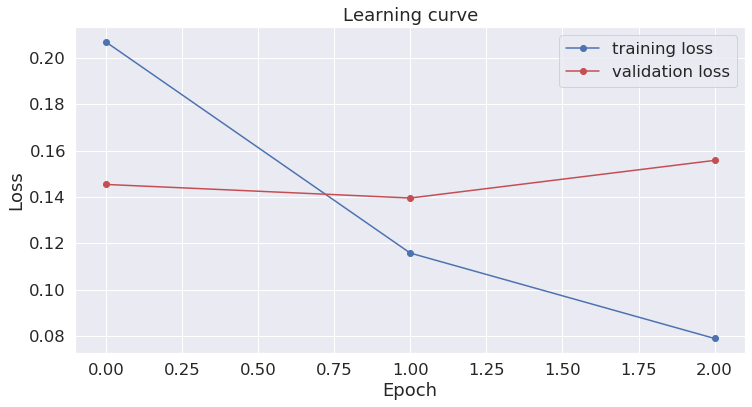

In [33]:
# Uncommend inline and show to show within the jupyter only.
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#plt.show()
#plt.savefig("training.png")

In [50]:
# TEST
predictions , true_labels = [], []
for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

results_predicted = [indices_to_tags[p_i] for p, l in zip(predictions, true_labels)
                             for p_i, l_i in zip(p, l) if indices_to_tags[l_i] != "PAD"]
results_true = [indices_to_tags[l_i] for l in true_labels
                              for l_i in l if indices_to_tags[l_i] != "PAD"]

100%|██████████| 733/733 [01:11<00:00, 10.18it/s]


In [52]:
print(f"F1 score: {f1_score(results_true, results_predicted)}")
print(f"Accuracy score: {accuracy_score(results_true, results_predicted)}")
print(classification_report(results_true, results_predicted))

F1 score: 0.8225421637186342
Accuracy score: 0.9597041489970306
           precision    recall  f1-score   support

      geo       0.84      0.89      0.87     10952
      gpe       0.95      0.94      0.94      3360
      per       0.78      0.80      0.79      4983
      org       0.73      0.71      0.72      6588
      tim       0.84      0.82      0.83      4077
      art       0.07      0.02      0.03       153
      nat       0.54      0.22      0.31        65
      eve       0.29      0.39      0.34        51

micro avg       0.82      0.83      0.82     30229
macro avg       0.81      0.83      0.82     30229



### You can try the model by executing the top cell, one of the tag cells in the beginning and everything after this cell

In [7]:
# Loading a model (see docs for different options)
model = torch.load('gmb_ner_bert_pt.pt', map_location=torch.device('cuda'))
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [8]:
test_sentence = """
As Harry rides the Hogwarts Express on his journey back from school after his fourth year and the dire Triwizard Tournament, he dreads disembarking from the train
"""

In [9]:
tokenized_sentence = tokenizer.encode(test_sentence)

if torch.cuda.is_available():
    input_ids = torch.tensor([tokenized_sentence]).cuda()
else:
    input_ids = torch.tensor([tokenized_sentence])


In [10]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [11]:
# Join BPE split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(indices_to_tags[label_idx])
        new_tokens.append(token)


In [12]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	As
B-per	Harry
O	rides
O	the
B-org	Hogwarts
I-org	Express
O	on
O	his
O	journey
O	back
O	from
O	school
O	after
O	his
B-tim	fourth
O	year
O	and
O	the
O	dire
O	Triwizard
O	Tournament
O	,
O	he
O	dreads
O	disembarking
O	from
O	the
O	train
